In [5]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import timm
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn

# Bounding boxes and XAI within Chest X-Ray14 dataset

Want to add gradcam to alexnet baseline and compare them to the bounding boxes in the dataset.

In [80]:
root_folder = '/cluster/home/taheeraa/datasets/chestxray-14/'
images_path = f"{root_folder}/images"
file_path_bbox = root_folder + 'BBox_List_2017.csv'

labels = [
        "Atelectasis", 
        "Cardiomegaly",
        "Effusion", 
        "Infiltration", 
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",  
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia"
    ]
num_labels = len(labels) 
# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']

df_bbox = pd.read_csv(file_path_bbox)
file_path_data_entry = root_folder + 'Data_Entry_2017.csv'
df_data_entry = pd.read_csv(file_path_data_entry)
merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
merged_df.rename(columns={
    'Bbox [x': 'x',
    'h]': 'h',
}, inplace=True)
merged_df['filepath'] = '/cluster/home/taheeraa/datasets/chestxray-14/images/' + merged_df['Image Index']
df = merged_df
df['Finding Label'] = df['Finding Label'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Assuming df is your dataframe
# Calculate the size of each bounding box
df['bbox_size'] = df['w'] * df['h']
df.head()

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath,bbox_size
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,Atelectasis,...,69,M,PA,2992,2991,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...,6871.772479
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,Atelectasis|Effusion|Mass,...,53,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...,58150.021258
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,Atelectasis,...,67,F,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...,33652.858374
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,Atelectasis|Cardiomegaly|Consolidation,...,51,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...,7801.344441
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,Atelectasis,...,75,F,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...,15673.289285


In [87]:
# Calculating average bounding box size for each disease
df['Finding Label'] = df['Finding Label']
avg_bbox_size = df.groupby('Finding Label')['bbox_size'].mean()
num_bboxes = df.groupby('Finding Label')['bbox_size'].count()

/tmp/ipykernel_703941/2525373005.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(avg_bbox_size.index, ha='center', size=12)


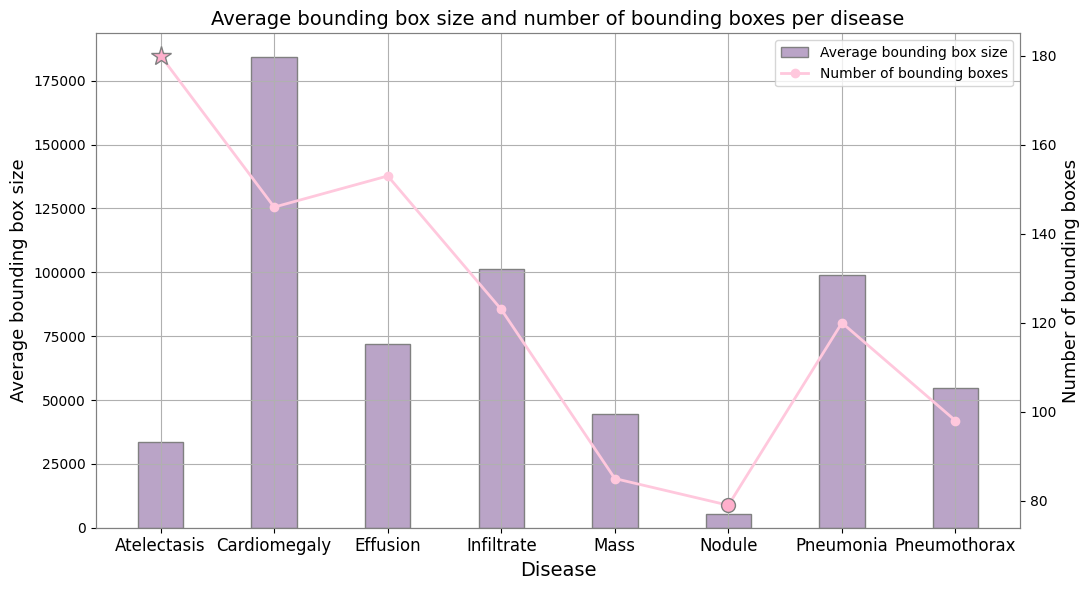

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the combined plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(11, 6))

# Plotting average bounding box size with bar plot
bar_width = 0.4  # set size of bars
ax1.set_xlabel('Disease', size=14)
ax1.set_ylabel('Average bounding box size', size=13)
bars = ax1.bar(avg_bbox_size.index, avg_bbox_size, color=colors_list[0], width=bar_width, edgecolor='gray', label="Average bounding box size")
ax1.tick_params(axis='y')
ax1.set_xticklabels(avg_bbox_size.index, ha='center', size=12)

# Create a second y-axis for the number of bounding boxes
color = colors_list[1]
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Number of bounding boxes', size=13)
line, = ax2.plot(num_bboxes.index, num_bboxes, color=color, marker='o', linestyle='-', linewidth=2, label="Number of bounding boxes")
ax2.tick_params(axis='y')

# Add a legend
plt.legend([bars, line], ['Average bounding box size', 'Number of bounding boxes'], loc='upper right')

# Highlight the highest and lowest points in the line plot
max_index = num_bboxes.idxmax()
min_index = num_bboxes.idxmin()
color = "#FFAFCC"
ax2.plot(max_index, num_bboxes[max_index], marker='*', markersize=15, color=color, label='Highest Point',markeredgecolor='gray')
ax2.plot(min_index, num_bboxes[min_index], marker='o', markersize=10, color=color, label='Lowest Point', markeredgecolor='gray')

# Title and grid
plt.title('Average bounding box size and number of bounding boxes per disease', size=14)
ax1.grid(True)

# Customize spine colors
for spine in ax1.spines.values():
    spine.set_edgecolor('grey')
for spine in ax2.spines.values():
    spine.set_edgecolor('gray')
# Adjust subplots and save the figure

# Adjust subplots and save the figure
fig.tight_layout()
plt.savefig('avg-bbox-size-number-bbox-per-disease.png')


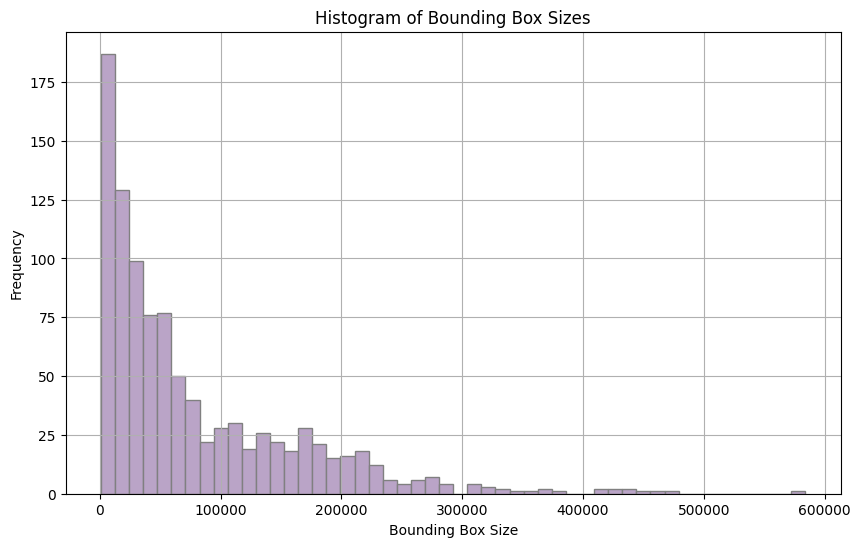

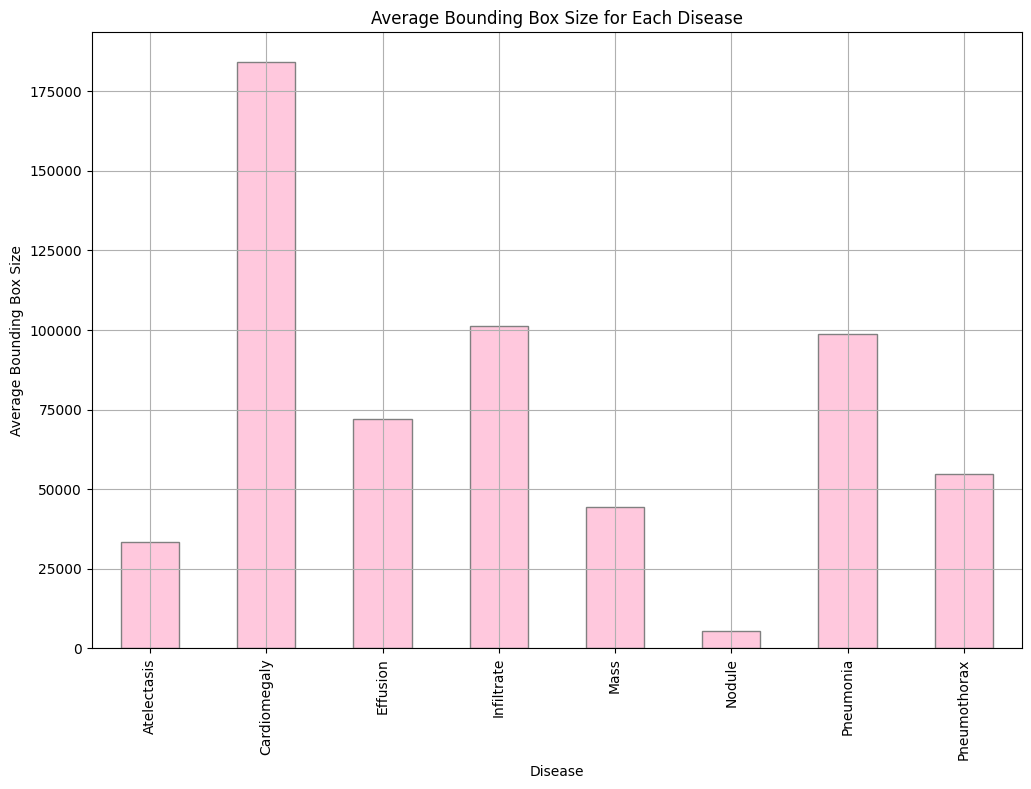

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the histogram of bounding box sizes
plt.figure(figsize=(10, 6))
plt.hist(df['bbox_size'], bins=50, color=colors_list[0], edgecolor='gray')
plt.title('Histogram of Bounding Box Sizes')
plt.xlabel('Bounding Box Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



# Plotting average bounding box size for each disease
plt.figure(figsize=(12, 8))
avg_bbox_size.plot(kind='bar', color=colors_list[1], edgecolor='gray')
plt.title('Average Bounding Box Size for Each Disease')
plt.xlabel('Disease')
plt.ylabel('Average Bounding Box Size')
plt.grid(True)
plt.show()


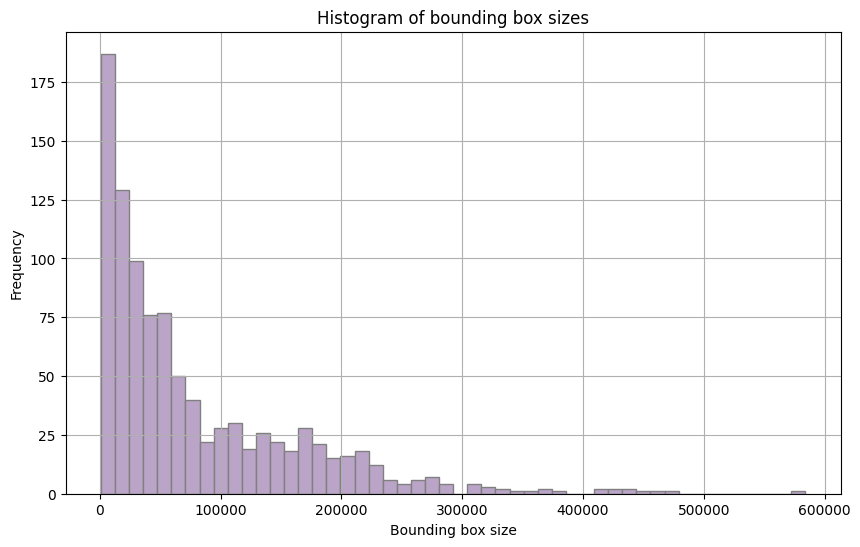

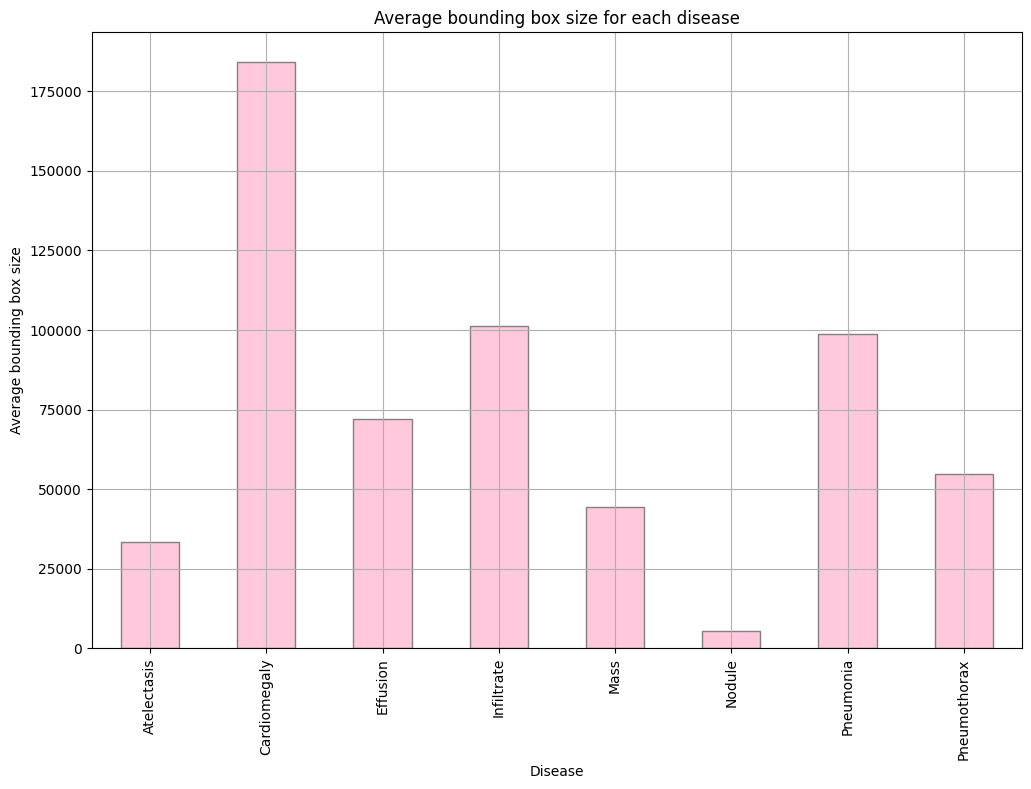

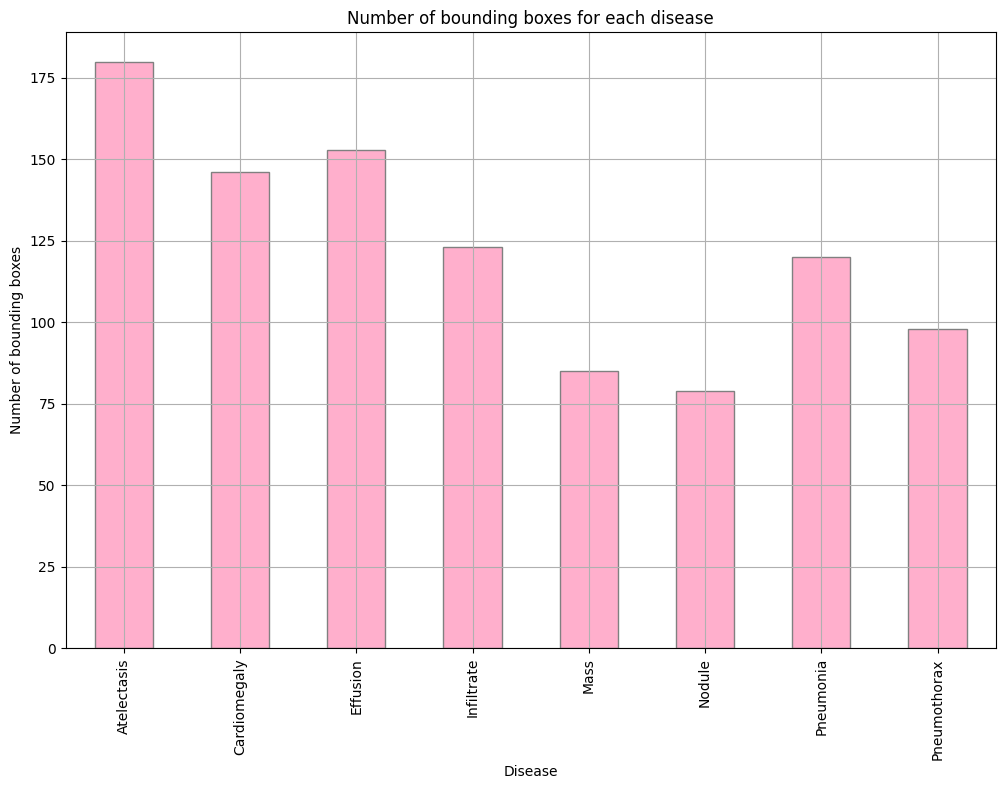

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the histogram of bounding box sizes
plt.figure(figsize=(10, 6))
plt.hist(df['bbox_size'], bins=50, color=colors_list[0], edgecolor='gray')
plt.title('Histogram of bounding box sizes')
plt.xlabel('Bounding box size')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('histogram_bbox_sizes.png')

# Plotting average bounding box size for each disease
plt.figure(figsize=(12, 8))
avg_bbox_size.plot(kind='bar', color=colors_list[1], edgecolor='gray')
plt.title('Average bounding box size for each disease')
plt.xlabel('Disease')
plt.ylabel('Average bounding box size')
plt.grid(True)
plt.savefig('average_bbox_size_per_disease.png')

# Plotting number of bounding boxes for each disease
plt.figure(figsize=(12, 8))
num_bboxes.plot(kind='bar', color=colors_list[2], edgecolor='gray')
plt.title('Number of bounding boxes for each disease')
plt.xlabel('Disease')
plt.ylabel('Number of bounding boxes')
plt.grid(True)
plt.savefig('number-of-bboxes-per-disease.png')

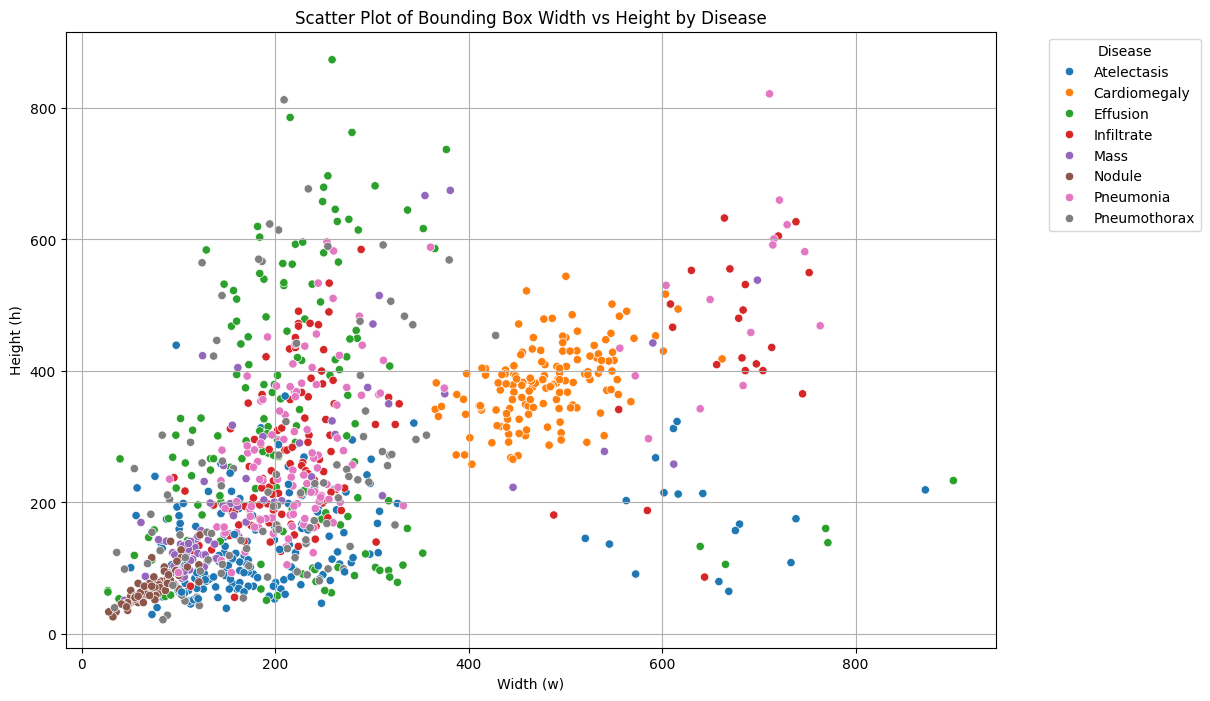

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your dataframe
# Split the 'Finding Label' column and explode it to have one disease per row
df['Finding Label'] = df['Finding Label'].str.split('|')
df_exploded = df.explode('Finding Label')

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_exploded, x='w', y='h', hue='Finding Label', palette='tab10')

# Add plot title and labels
plt.title('Scatter Plot of Bounding Box Width vs Height by Disease')
plt.xlabel('Width (w)')
plt.ylabel('Height (h)')
plt.legend(title='Disease', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()

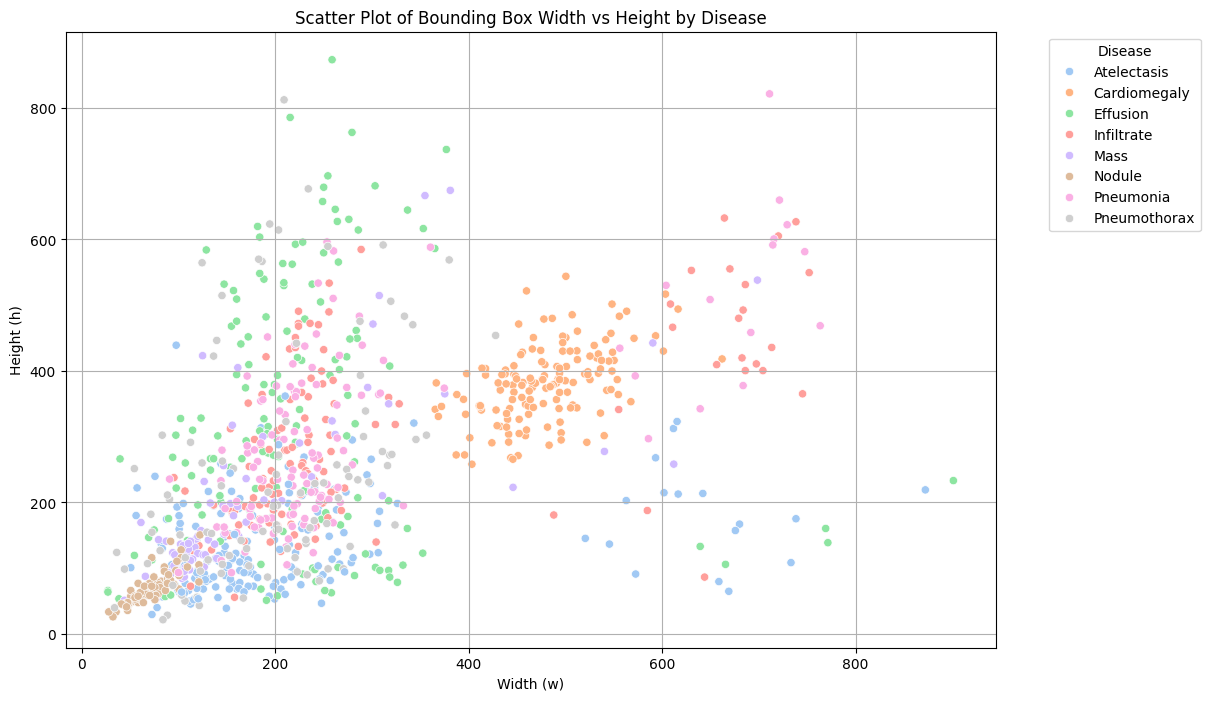

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# Assuming df is your dataframe
# Split the 'Finding Label' column and explode it to have one disease per row
df['Finding Label'] = df['Finding Label'].str.split('|')
df_exploded = df.explode('Finding Label')


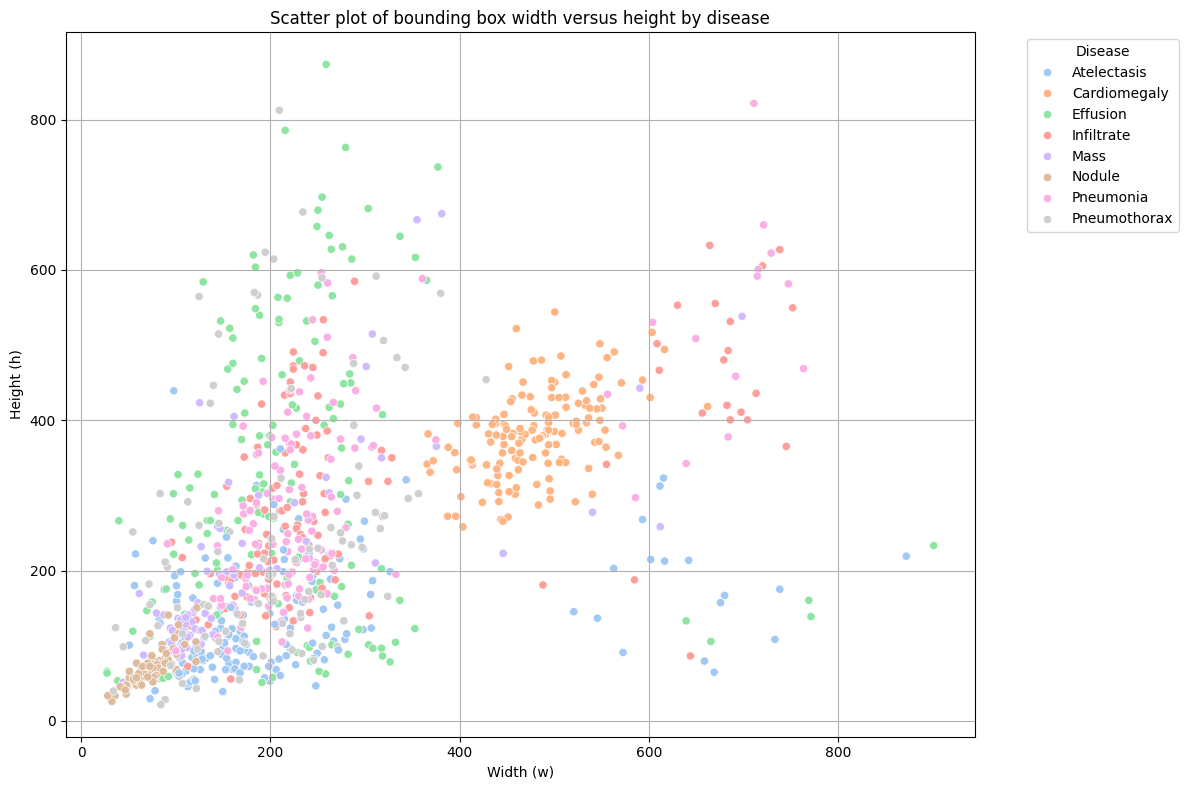

In [67]:

# Define the color palette using a linear segmenter
num_colors = df_exploded['Finding Label'].nunique()
colors_list = ['#BAA4C7', '#FFAFCC', '#BDE0FE','#A2D2FF']
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors_list, N=num_colors)
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Create a dictionary to map each unique disease to a color
unique_labels = df_exploded['Finding Label'].unique()
palette = {label: color for label, color in zip(unique_labels, colors)}

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_exploded, x='w', y='h', hue='Finding Label', palette='pastel')

# Add plot title and labels
plt.title('Scatter plot of bounding box width versus height by disease')
plt.xlabel('Width (w)')
plt.ylabel('Height (h)')
plt.legend(title='Disease', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
# Show plot
plt.savefig('bbox-sizes-dataset.png')


In [24]:
df['Finding Label'] = df['Finding Label'].apply(lambda x: x[0] if isinstance(x, list) else x)
col_img_index_df = df[df['Image Index'] == '00013461_011.png']
col_img_index_df

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath,bbox_size
787,00013461_011.png,Pneumonia,157.582222,125.477934,711.111111,821.475556,NaN,NaN,NaN,Edema|Pneumonia,...,28,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...,584160.395062


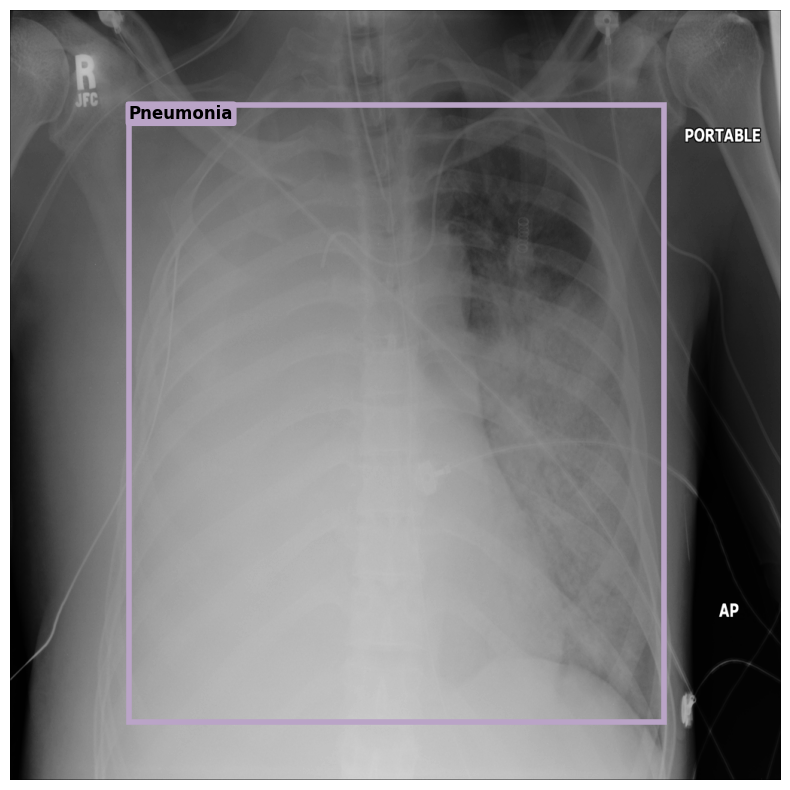

In [26]:


unique_labels = col_img_index_df['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(
    colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(col_img_index_df['filepath'].values[0])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

# First subplot: Image with bounding boxes
ax1 = axs
ax1.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in col_img_index_df.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4,
                                edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold',
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

ax1.axis('off')
plt.show()